In [1]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from scipy.special import erfc
from lmfit.models import SkewedGaussianModel
%matplotlib inline

In [2]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals=[];ymeas=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals.append(float(items[0]))
    ymeas.append(float(items[1]))
    
xvals = np.array(xvals[1670:1730])
ymeas = np.array(ymeas[1670:1730])

infile.close()

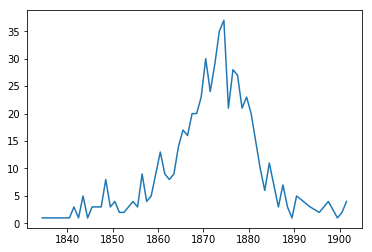

In [3]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [4]:
'''
def gauss_fn(p0, x):
    
    amp,mu,sigma,gamma = p0
    model = SkewedGaussianModel()
        #amp*=sigma*np.sqrt(2*np.pi)
    
    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma, gamma=gamma)
    ymod = model.eval(params=params,x=x)
    
    return ymod
'''

def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod

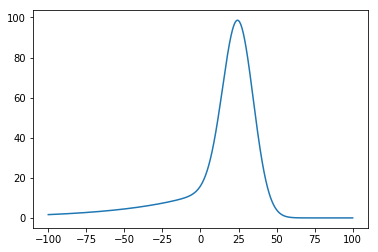

In [5]:
#test to see if this function looks correct
x = np.arange(-100, 100, step = 0.001)
y = gf3([100, 25, 10, 10,50],x)

#y = np.exp(((x-5)/5)) * erfc(((x-5)/(10*2**0.5)) + 2/(5*2**0.5 ))
pl.plot(x,y)

pl.show()

In [6]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    #ymod = gauss_fn(p0,x)
    ymod = gf3(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    #if np.isnan(ll):
    #    ll = -35
    #print(ll)
    return ll

In [7]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess width:
s0 = 10.

# just guess r and beta from what they usually turn out about from experience
r0 = 10.
b0 = 5.

# adjust the amplitude for the normalisation factor:
#a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s0,r0,b0)
p0 = np.array([a0,m0,s0,r0,b0])

37.0 1874.5 10.0 10.0 5.0


In [8]:
bnds = ((None,None), (None,None), (0.,None), (0., 100), (0.,None))

print(len(p0))
print(len(bnds))

5
5


In [9]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]
print(result["success"])
print(result["status"])
print(result["message"])
p1cov = result["hess_inv"].todense()
print(p1)
p1cov[np.isnan(p1cov)] = 0
p1err = p1cov.diagonal()
print(p1cov)

True
0
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
[  28.95438703 1874.29499401    7.07064366   15.49938204   20.70027834]
[[   8.37120903    2.65336641   -1.59052665   18.55911898  -21.53809619]
 [   2.65336641    1.85686725   -0.69070347   10.66768777  -10.39426366]
 [  -1.59052665   -0.69070347    0.49638923   -5.86664553    6.01397982]
 [  18.55911898   10.66768777   -5.86664553  145.90394671 -149.64989617]
 [ -21.53809619  -10.39426366    6.01397982 -149.64989617  160.35240148]]


In [22]:
def pyield(A, s, r, b):
    part1 = s * np.sqrt(2 * np.pi) * A * (1 - r/100)
    part2 = 2 * A * r * b/100 * np.exp(-(s**2)/(2 * b**2))
    
    return part1 + part2

print(np.sum(ymeas))
Y = pyield(p1[0], p1[2], p1[3], p1[4])
print(Y)

609.0
608.9007575489355


In [23]:
def yerr(Y,A,s,r,b,cov):
    
    dYdA = Y/A
    dYdr = (Y - s * np.sqrt(2 * np.pi) * A)/r
    dYds = np.sqrt(2 * np.pi) * A * (1 - r/100) - (2 * A * r * s * np.exp(-s**2/(2 * b**2)))/ (100 * b)
    dYdb = (2/100) * A * r *  np.exp(-s**2/(2 * b**2)) * (1 + s**2/b**2)
    
    vAA, vAm, vAs,vAr, vAb = cov[0]
    vmA, vmm, vms,vmr, vbb = cov[1]
    vsA, vsm, vss,vsr, vsb = cov[2]
    vrA, vrm, vrs,vrr, vrb = cov[3]
    vbA, vbm, vbs,vbr, vbb = cov[4]
    
    vY = (dYdA**2 * vAA) + (dYds**2 * vss) + (dYdr**2 * vrr) + (dYdb**2 * vbb) + (2 * dYdA * dYds * vAs) + (2 * dYdA * dYdr * vAr) + (2 * dYdA * dYdb * vAb) + (2 * dYds * dYdr * vsr) + (2 * dYds * dYdb * vsb) + (2 * dYdr * dYdb * vrb)
    return(vY)    
    
err = yerr(Y, p1[0], p1[2], p1[3], p1[4], p1cov)

print(Y, '+-', np.sqrt(np.abs(err)))

608.9007575489355 +- 50.76708777294732


In [53]:
print(p1cov, '\n\n')

def shrinkcov(cov,i, fixrb):
    shape = np.shape(cov)
    if fixrb == False:
        for j,row in enumerate(cov):
            if i != j:
                if not np.array_equal(row, cov[-1]):
                    if not np.array_equal(row, cov[-2]):
                        if not np.array_equal(row, cov[-3]):
                            print('\n\n\n',row,cov[-1], '\n\n\n')
                            cov = np.delete(cov,j)
                            print(cov)
                            cov = np.reshape(cov,(shape[0], shape[1] - 1)) 
                            print(cov)
    return(cov)
print(shrinkcov(p1cov, 0, False))

[[   8.37120903    2.65336641   -1.59052665   18.55911898  -21.53809619]
 [   2.65336641    1.85686725   -0.69070347   10.66768777  -10.39426366]
 [  -1.59052665   -0.69070347    0.49638923   -5.86664553    6.01397982]
 [  18.55911898   10.66768777   -5.86664553  145.90394671 -149.64989617]
 [ -21.53809619  -10.39426366    6.01397982 -149.64989617  160.35240148]] 





 [  2.65336641   1.85686725  -0.69070347  10.66768777 -10.39426366] [ -21.53809619  -10.39426366    6.01397982 -149.64989617  160.35240148] 



[   8.37120903   -1.59052665   18.55911898  -21.53809619    2.65336641
    1.85686725   -0.69070347   10.66768777  -10.39426366   -1.59052665
   -0.69070347    0.49638923   -5.86664553    6.01397982   18.55911898
   10.66768777   -5.86664553  145.90394671 -149.64989617  -21.53809619
  -10.39426366    6.01397982 -149.64989617  160.35240148]


ValueError: cannot reshape array of size 24 into shape (5,4)

-35.55273258476643


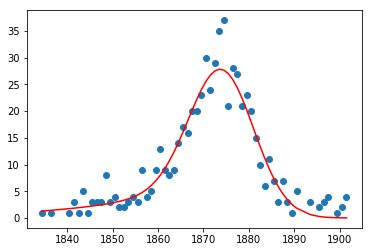

In [12]:

yfit = gf3(p1,xvals)

fig = pl.figure(1)

ax = fig.add_subplot(111)

ax.scatter(xvals,ymeas)
ax.plot(xvals,yfit,c='r')

fig.savefig("gf3fit.png")

print(lnlike(p1, xvals, ymeas))

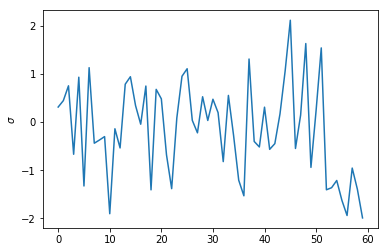

In [13]:
res = (yfit - ymeas)/np.sqrt(ymeas)
fig = pl.figure(1)
ax = fig.add_subplot(111)
pl.plot(res)
pl.ylabel(r"$\sigma$")
fig.savefig("residuals.png")

These residuals still look weird.

---

In [14]:
ndim, nwalkers = 5, 500
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [16]:
p0 = sampler.run_mcmc(pos, 250) #this doesn't work with 500 as it tries to use a negative value of r

NaN value of lnprob for parameters: 
[ 2.92275372e+01  1.87236318e+03  7.51804229e+00 -8.74657216e-01
  4.17651208e+01]


/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


ValueError: lnprob returned NaN.

In [ ]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
print(samples.shape)

In [ ]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$","$r$", "$beta$"],
                      truths=[a0, m0, s0, r0, b0])
fig.savefig("triangle.png")
print(p1cov)

In [ ]:
#now do it with a multiplet
xvals = np.array(xvals2[1300:1650])
ymeas = np.array(ymeas2[1300:1650])

pl.plot(xvals,ymeas)
pl.show()

In [ ]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    npeaks = int((len(p0)-3)/2)
    ymod = 0
    for i in range(npeaks):
        p1 = [p0[i * 2], p0[i * 2 + 1], p0[-3], p0[-2], p0[-1]]
        ymod += gf3(p1,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [ ]:
bnd = ((0,None), (None,None), )
metabnd = ((0.1,10), (0.1, 100), (0.1,None))
#bnds2 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
#bnds3 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
#bnds4 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))

bnds = []

for peak in range(5):
    for bound in bnd:
        bnds.append(bound)

for bound in metabnd:
    bnds.append(bound)
        
bnds
#len(p0) == len(bnds)



In [ ]:
mu1 = 1485
A1 = np.max(ymeas[int(np.where(xvals == mu1 + 0.5)[0]) - 5 : int(np.where(xvals == mu1 + 0.5)[0]) + 5 ])

mu2 = 1520
A2 = np.max(ymeas[int(np.where(xvals == mu2 + 0.5)[0]) - 5 : int(np.where(xvals == mu2 + 0.5)[0]) + 5 ])

mu3 = 1620
A3 = np.max(ymeas[int(np.where(xvals == mu3 + 0.5)[0]) - 5 : int(np.where(xvals == mu3 + 0.5)[0]) + 5 ])

mu4 = 1650
A4 = np.max(ymeas[int(np.where(xvals == mu4 + 0.5)[0]) - 5 : int(np.where(xvals == mu4 + 0.5)[0]) + 5 ])

mu5 = 1670
A5 = np.max(ymeas[int(np.where(xvals == mu5 + 0.5)[0]) - 5 : int(np.where(xvals == mu5 + 0.5)[0]) + 5 ])

sig = 2
r = 30
b = 15

g1 = [A1,mu1]
g2 = [A2,mu2]
g3 = [A3,mu3]
g4 = [A4,mu4]
g5 = [A5,mu5]

mets = [sig,r,b]

p0 = []

for peak in [g1,g2,g3,g4,g5,mets]:
    for parameter in peak:
        p0.append(parameter)



A1

In [ ]:
result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [ ]:
print(p1)

npeaks = int((len(p1) - 3)/2)
npeaks
ymod = 0
for i in range(npeaks):
    p2 = [p1[i * 2], p1[i * 2 + 1], p1[-3], p1[-2], p1[-1]]
    #print(p2)
    ymod += gf3(p2,xvals)

ymodinit = 0    
for i in range(npeaks):
    p3 = [p0[i * 2], p0[i * 2 + 1], p0[-3], p0[-2], p0[-1]]
    #print(p2)
    ymodinit += gf3(p3,xvals)
    
#thing = 
pl.plot(xvals, ymod)
#pl.plot(xvals, ymodinit)
pl.plot(xvals,ymeas)
pl.show()


In [ ]:
#this is why we fix the relative widths